In [133]:
import numpy as np
import scipy.sparse as sparse
from time import time

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

import FastALS
import RiemannianOptimization
import ALS
#import SoftInput

from tqdm import tqdm

In [134]:
def generate_random_problem(rows, cols, fill_coef, true_rank, random_state):
    
    """
    Generate random matrix completion problem
    
    Args:
        rows (int) number of rows
        cols (int) number of collomns
        fill_coef (float) [0, 1]: coefficient of observed values
        true_rank (int): True rank of matrix
        random_state (int): random state for repetition of the results
    
    
    Returns:
        X (np.array): Completed matrix of the problem
        Xw (csr_matrix): Matrix with missed values
    """
    
    np.random.seed(random_state)

    diag = np.random.uniform(0, 1, true_rank)
    diag = np.sort(diag)[::-1]
        
    S = np.diag(diag)
    U = np.random.uniform(0, 1, (rows, true_rank))
    V = np.random.uniform(0, 1, (cols, true_rank))
        
    Qu, Ru = np.linalg.qr(U)
    Qv, Rv = np.linalg.qr(V)
    
    X = Qu.dot(S).dot(Qv.T)
    
    num = int(X.size * fill_coef)

    np.random.seed(random_state)
    row_ind = np.random.randint(0, rows, size=num)
    col_ind = np.random.randint(0, cols, size=num)

    Xw = sparse.csr_matrix((X[(row_ind, col_ind)], (row_ind, col_ind)), shape=X.shape, dtype=np.float)
    
    return X, Xw

# The 1-st  experiment. Comparison of ALS and FastALS for different problems.

**In this experiment we consider 4 different problems and we will try to find out how the size and the number of nonzero elements influence on the behaviour of our algorithms.**

In [135]:
first = {'m': 200, 'n': 200, 'true_rank': 50, 'fill_coef': 0.3, 'approx_rank': 25, 'reg_coef': 0.3}
second = {'m': 800, 'n': 400, 'true_rank': 100, 'fill_coef': 0.3, 'approx_rank': 50, 'reg_coef': 0.3}
third = {'m': 1000, 'n': 900, 'true_rank': 200, 'fill_coef': 0.3, 'approx_rank': 50, 'reg_coef': 0.3}
forth = {'m': 1000, 'n': 900, 'true_rank': 200, 'fill_coef': 0.1, 'approx_rank': 50, 'reg_coef': 0.3}
problems = [first, second, third, forth]

100%|██████████| 4/4 [07:13<00:00, 108.39s/it]


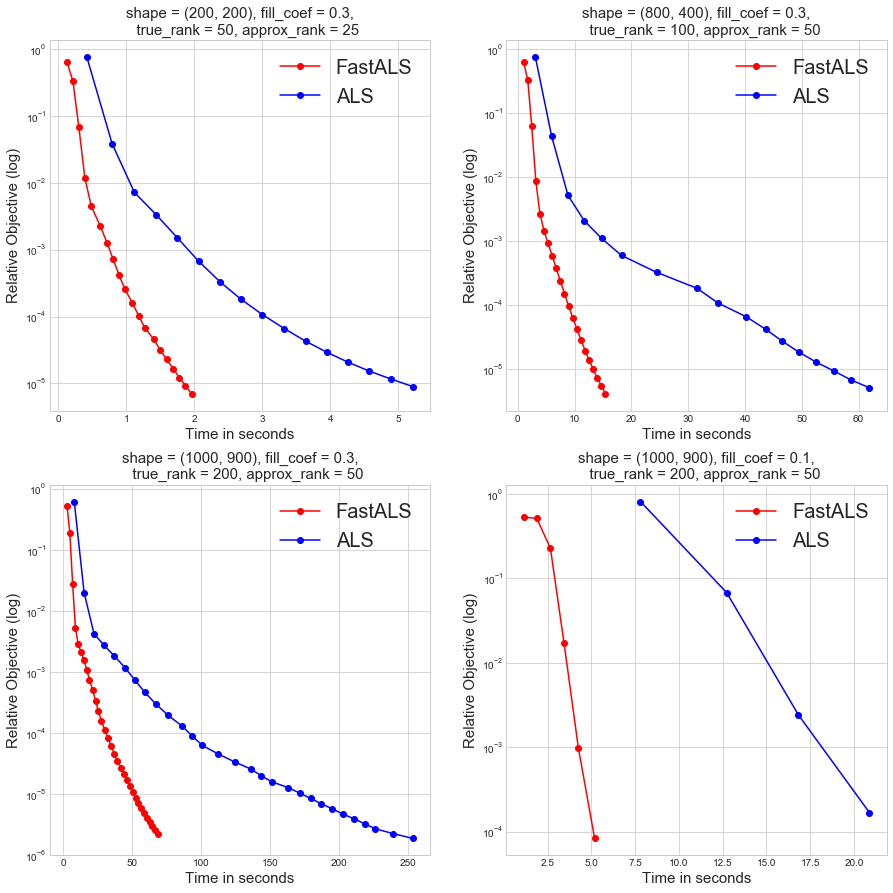

--- 434.8655948638916 seconds ---


In [4]:
fig = plt.figure(figsize=(15, 15))

max_iter = 50
tol = 1e-5

start_time = time()

for it in tqdm(range(0, 4)):
    m = problems[it]['m']
    n = problems[it]['n']
    reg_coef = problems[it]['reg_coef']
    true_rank = problems[it]['true_rank']
    fill_coef = problems[it]['fill_coef']
    approx_rank = problems[it]['approx_rank']
    
    X, Xw = generate_random_problem(rows=m, cols=n, fill_coef=fill_coef, true_rank = true_rank, random_state=1)
    
    
    fast_als = FastALS.FastALS(rank=approx_rank, max_iter=max_iter, tol=tol, reg_coef=reg_coef)
    fast_als.fit(Xw, trace=True, debug_mode=False)
    
    als = ALS.ALS(rank=approx_rank, max_iter=max_iter, tol=tol, reg_coef=reg_coef)
    als.fit(Xw, trace=True, debug_mode = False)
    

    plot = fig.add_subplot(2, 2, it+1, yscale = 'log')
    
    plot.set_xlabel('Time in seconds', size = 15)
    plot.set_ylabel('Relative Objective (log)', size = 15)
    
    plot.plot(fast_als.get_time(), np.abs(fast_als.get_rel_obj()), '-o', c='r', label = 'FastALS')
    plot.plot(als.get_time(), np.abs(als.get_rel_obj()), '-o', c='b', label = 'ALS')
    
    plot.set_title("""shape = ({0}, {1}), fill_coef = {2},
    true_rank = {3}, approx_rank = {4}""".format(m, n, fill_coef, true_rank, approx_rank))
    plot.title.set_fontsize(15)
    plot.legend(loc = 'upper right', prop={'size': 20})
    
    
plt.show()
print("--- %s seconds ---" % (time() - start_time))

# Conclusion about the 1-st experiment:

**These plots show relative changing for both ALS and FastALS algorithms. As we can see FastALS "faster" stabilizy changing in the objective. In averaging, as we can see, ALS requires two times bigger time to achieve the  same accuracy in changing of the objective function as FastALS. **


**If we increasy the size of the problem , staying the number of ninzero elements constatn, we indeed will see, that we algorithms require more computational time.**

**If we consider the problem of the same sizes and consider different amount of nonzero elements, we can see, that if we decreasy the number of nonzero elememnts  than training time will also decreasy, This is because of efficient sparse calculations. As FastALS use sparse + nonsparse structer in the very efficient way.**

**ALS solves different regression problem for every row/column, because of their different amount of missingness. This can be costly. 
FastALS solves a single regresiion problem once and simultaneously for all rows/columns, because it operates on a filled-in matrix which is complete.**

**In the next experiment we will see, the behaviour for r_k (that is ||Approx_old - Approx_new||^2. And we will state, that FastALS has better convergence for local minimum than a simple ALS. We also consider the RiemannianOptimization algorithm.**

# The 2-nd experiment: Convergence behaviour for different algorithms.

In [105]:
problem_params  = {'m': 500, 'n': 400, 'true_rank': 100, 'fill_coef': 0.2, 'approx_rank': 30, 'reg_coef': 0.3}

In [106]:
m = problem_params['m']
n = problem_params['n']
reg_coef = problem_params['reg_coef']
true_rank = problem_params['true_rank']
fill_coef = problem_params['fill_coef']
approx_rank = problem_params['approx_rank']
    
X, Xw = generate_random_problem(rows=m, cols=n, fill_coef=fill_coef, true_rank = true_rank, random_state=1)

In [130]:
max_iter = 100
tol = 1e-6
sample_number = 7

In [131]:
fast_als = FastALS.FastALS(rank=approx_rank, max_iter=max_iter, tol=tol, reg_coef=reg_coef)
fast_als.fit(Xw, trace=True, debug_mode=False, random_state = 123)
    
als = ALS.ALS(rank=approx_rank, max_iter=max_iter, tol=tol, reg_coef=reg_coef)
als.fit(Xw, trace=True, debug_mode = False, random_state=123)
    
riman = RiemannianOptimization.RiemannianOptimization(rank=approx_rank, 
                                                          max_iter=max_iter, tol=tol, reg_coef=reg_coef)
riman.fit(Xw, trace=True, debug_mode = False, random_state=123)

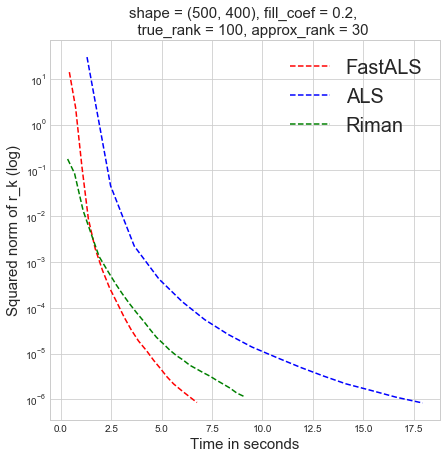

In [132]:
fig = plt.figure(figsize=(7, 7))

plot = fig.add_subplot(1, 1, 1, yscale = 'log')
    
plot.set_xlabel('Time in seconds', size = 15)
plot.set_ylabel('Squared norm of r_k (log)', size = 15)
    
plot.plot(fast_als.get_time(), fast_als.get_diff_norm(), '--', c='r', label = 'FastALS')
plot.plot(als.get_time(), als.get_diff_norm(), '--', c='b', label = 'ALS')
plot.plot(riman.get_time(), riman.get_diff_norm(), '--', c='g', label = 'Riman')


    
plot.set_title("""shape = ({0}, {1}), fill_coef = {2}, 
    true_rank = {3}, approx_rank = {4}""".format(m, n, fill_coef, true_rank, approx_rank))
plot.title.set_fontsize(15)
plot.legend(loc = 'upper right', prop={'size': 20})

# Conclusion about the 2-nd experiment:

**As we can see the rate of convergence $\|r_k\|^2 \to 0$ for ALS is the weakest. Now consider the other two algorithms. RiemannianOptimization faster than all reaches accuracy in $10^{-2}$, but later begins to lose FastALS. I can try to explain this as follows: On each iteration RiemannianOptimization do a lot of cost operations, like producing SVD of reaaly big matrices, projection on Manifold and so on. This powerfull methods give the RiemannianOptimization method the opportinity to reach a good accuracy, using only several steps. But furthemore, on each iteration it do line search, and as a every gradient method for him it may be difficult to find an appropriate step fot next iteration, because manifold at the local optimum may have a specila structer. So, We may try to consider some modifications of this method, to improve his rate of convergence near local optimum.**

 # 3 Experiment